<a href="https://colab.research.google.com/github/ampnb/machine-learning2022/blob/main/05_Newton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Wanchanok Sunthorn"
ID = "st122053"

---

# Lab 05: Optimization Using Newton's Method

In this lab, we'll explore an alternative to gradient descent
for nonlinear optimization problems: Newton's method.

## Newton's method in one dimension

Consider the problem of finding the *roots* $\textbf{x}$ of a nonlinear function $f: \mathbb{R}^N \rightarrow \mathbb{R}$. A root of $f$ is a point $\mathbf{x}$ that satisfies $f(\mathbf{x}) = 0$.

In one dimension, Newton's method for finding zeroes works as follows:

1. Pick an initial guess $x_0$

2. Let $x_{i+1} = x_i + \frac{f(x_i)}{f'(x_i)}$

3. If not converged, go to #2.

Convergence occurs when $|f(x_i)| < \epsilon_1$ or when $|f(x_{i+1})-f(x_i)| < \epsilon_2$.

Let's see how this works in practice.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

### Example 1: Root finding for cubic polynomial 

In [ ]:
def fx(x, p):
    f_x = np.polyval(p, x)
    return f_x

In [ ]:
n = 200
x = np.linspace(-3, 3, n)  

# Create the polynomial f(x) = x^3 + x^2 
p = np.poly1d([1, 1, 0, 0]) # [x^3, x^2, x^1, 1]

# Derivative of a polynomial
# This is a convenient method to obtain p_d = np.poly1d([3, 2, 0])
p_d = np.polyder(p)
print('p derivative:', p_d)
print('p derivative:', p_d[2], p_d[1], p_d[0])

# Get values for f(x) and f'(x) for graphing purposes
y = fx(x, p)
y_d = fx(x,p_d)

p derivative:    2
3 x + 2 x
p derivative: 3 2 0


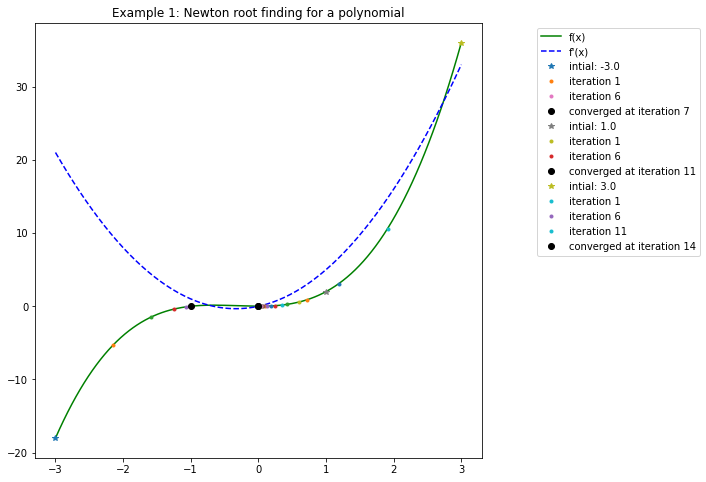

In [ ]:
# Try three possible guesses for x0
x0_arr = [-3.0, 1.0, 3.0]
max_iter = 30
threshold = 0.001
roots = []

fig1 = plt.figure(figsize=(8,8)) 
ax = plt.axes()
plt.plot(x, y, 'g-', label='f(x)')
plt.plot(x, y_d, 'b--', label="f\'(x)")

for x0 in x0_arr:
    # Plot initial data point
    plt.plot(x0, fx(x0,p), '*', label='intial: ' + str(x0))    
    i = 0
    while i < max_iter:
        # x1 = x0 - f(x0)/f'(x0)
        x1 = x0 - fx(x0, p) / fx(x0, p_d)
        # Check for delta (x) less than threshold
        if np.abs(x0 - x1) <= threshold:
            roots.append(round(x1,4))
            break;
        # Plot current root after every 5 iterations
        if i % 5 == 0:
            plt.plot(x1, fx(x1, p), '.', label='iteration '+ str(i+1))
        else:
            plt.plot(x1, fx(x1, p), '.')        
        x0 = x1
        i = i + 1
    plt.plot(x1, fx(x1, p), 'ko', label='converged at iteration '+ str(i+1))

plt.legend(bbox_to_anchor=(1.5, 1.0), loc ='upper right')
plt.title('Example 1: Newton root finding for a polynomial')

plt.show()

#### Example 2: Root finding for sine function

In [ ]:
def fx_sin(x):  
    f_x = np.sin(x)        
    return f_x

def fx_dsin(x):    
    return np.cos(x)

In [ ]:
n = 200

x = np.linspace(-np.pi, np.pi, n)  

# Get f(x) and f'(x) for plotting
y = fx_sin(x)
y_d = fx_dsin(x)

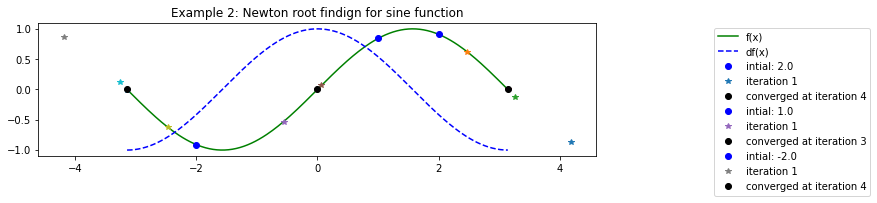

Roots: 3.141593, 0.000000, -3.141593


In [ ]:
# Consider three possible starting points
x0_arr = [2.0, 1.0, -2.0]
max_iter = 30
i = 0
threshold = 0.01
roots = []

fig1 = plt.figure(figsize=(10,10)) 
ax = plt.axes()
ax.set_aspect(aspect = 'equal', adjustable = 'box')
plt.plot(x, y, 'g-', label='f(x)')
plt.plot(x, y_d, 'b--', label='df(x)')

for x0 in x0_arr:
    plt.plot(x0, fx_sin(x0), 'bo', label='intial: ' + str(x0))
    i = 0;
    while i < max_iter:
        x1 = x0 - fx_sin(x0) / fx_dsin(x0)
        if np.abs(x0 - x1) <= threshold:
            roots.append(x1)
            plt.plot(x1,fx_sin(x1),'ko',label='converged at iteration '+ str(i))
            break;
        if i % 5 == 0:
            plt.plot(x1, fx_sin(x1), '*', label='iteration '+ str(i+1))
        else:
            plt.plot(x1, fx_sin(x1), '*')        
        x0 = x1
        i = i + 1

plt.legend(bbox_to_anchor=(1.5, 1.0), loc ='upper right')
plt.title('Example 2: Newton root findign for sine function')

plt.show()

print('Roots: %f, %f, %f' % (roots[0], roots[1], roots[2]))


## Newton's method for optimization

Now, consider the problem of minimizing a scalar function $J : \mathbb{R}^n \mapsto \mathbb{R}$.
We would like to find
$$ \theta^* = \text{argmin}_\theta J(\theta) $$
We already know gradient descent:
$$ \theta^{(i+1)} \leftarrow \theta^{(i)} - \alpha \nabla_J(\theta^{(i)}).$$
But Newton's method gives us a potentially faster way to find $\theta^*$ as a zero of
the system of equations
$$\nabla_J(\theta^*) = \mathbf{0}.$$

In one dimension, to find the zero of $f'(x)$, obviously, we would apply Newton's method
to $f'(x)$, obtaining the iteration
$$x_{i+1} = x_i - f'(x_i) / f''(x_i).$$
The multivariate extension of Newton's optimization method is
$$\mathbf{x}_{i+1} = \mathbf{x}_i - \mathtt{H}_f(\mathbf{x}_i) \nabla_f(\mathbf{x}_i),$$
where $\mathtt{H}_f(\mathbf{x})$ is the *Hessian* of $f$ evaluated at $\textbf{x}$:
$$\mathtt{H}_f(\mathbf{x}) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 x_n} \\
\frac{\partial^2 f}{\partial x_2 x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n x_1} & \frac{\partial^2 f}{\partial x_n x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}$$

This means, for the minimization of $J(\theta)$, we would obtain the update rule
$$\theta^{(i+1)} \leftarrow \theta^{(i)} - \mathtt{H}_J(\theta^{(i)}) \nabla_J(\theta^{(i)}).$$


## Application to logistic regression

Let's create some difficult sample data as follows:

**Class 1:** Two features $x_1$ and $x_2$ jointly distributed as a two-dimensional spherical Gaussian with parameters

$$\mu = \begin{bmatrix} x_{1c} \\ x_{2c} \end{bmatrix},
\Sigma = \begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_1^2 \end{bmatrix}.$$

**Class 2:** Two features $x_1$ and $x_2$ in which the data are generated by first sampling an angle $\theta$ according to a uniform distribution, sampling a distance $d$ according to a one-dimensional Gaussian with a mean of $(3\sigma_1)^2$ and a variance of $(\frac{1}{2}\sigma_1)^2$, then outputting the point $$\textbf{x} = \begin{bmatrix} x_{1c} + d \cos\theta \\ x_{2c} + d \sin\theta \end{bmatrix}$$.

Generate 100 samples for each of the classes.

### Exercise 1.1 (5 points)

Generate data for class 1 with 100 samples

$$\mu = \begin{bmatrix} x_{1c} \\ x_{2c} \end{bmatrix},
\Sigma = \begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_1^2 \end{bmatrix}.$$

<details>
    <summary><font size="3" color="green"><b>Hint:</b></font></summary>
    You can use <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html">numpy.random.multivariate_normal</a> to generate samples.
</details>

In [ ]:
mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
#Code Here
# การสร้างค่าสุ่มตามการแจกแจงแบบปกติหลายตัวแปรในไพธอนมีฟังก์ชัน np.random.multivariate_normal
# วิธีใช้คือ np.random.multivariate_normal(จุดกึ่งกลาง, เมทริกซ์ความแปรปรวนร่วมเกี่ยว, จำนวนที่ต้องการสุ่ม)

cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean = mu_1, cov=cov_mat, size=num_sample)


#raise NotImplementedError()

In [ ]:
print(X1[:5])

# Test function: Do not remove
assert X1.shape == (100, 2), 'Size of X1 is incorrect'
assert cov_mat.shape == (2, 2), 'Size of x_test is incorrect'
count = 0 
for i in range(2):
    for j in range(2):
        if i==j and cov_mat[i,j] != 0:
            if cov_mat[i,j] == sigma_1:
                count += 1
        else:
            if cov_mat[i,j] == 0:
                count += 1
assert count == 4, 'cov_mat data is incorrect'

print("success!")
# End Test function

[[2.5825743  1.64633856]
 [0.27711021 3.20417491]
 [0.36320392 3.51182354]
 [1.68804095 4.2429314 ]
 [0.47136879 3.64631716]]
success!


**Expect result (or looked alike):**\
[[-0.48508229  2.65415886]\
 [ 1.17230227  1.61743589]\
 [-0.61932146  3.53986541]\
 [ 0.70583088  1.45944356]\
 [-0.93561505  0.2042285 ]]

### Exercise 1.2 (5 points)

Generate data for class 2 with 100 samples

$$\textbf{x} = \begin{bmatrix} x_{1c} + d \cos\theta \\ x_{2c} + d \sin\theta \end{bmatrix}$$.

with a mean of $(3\sigma_1)^2$ and a variance of $(\frac{1}{2}\sigma_1)^2$

<details>
    <summary><font size="3" color="green"><b>Hint:</b></font></summary>
    You can use <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html">numpy.random.uniform</a> and/or <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html">numpy.random.normal</a> to generate samples.
</details>

In [ ]:
# 1. Create sample angle from 0 to 2pi with 100 samples
angle = None
# 2. Create sample with normal distribution of d with mean and variance
d =  None
# 3 Create X2
X2 = None

# YOUR CODE HERE
angle = np.random.uniform(0, 2*np.pi, 100)
d = np.random.normal(np.square(3*sigma_1),np.square(0.5 * sigma_1),num_sample)
X2 = np.array([X1[:,0]+d*np.cos(angle), X1[:,1]+d*np.sin(angle)]).T

#raise NotImplementedError()

In [ ]:
print('angle:',angle[:5])
print('d:', d[:5])
print('X2:', X2[:5])

# Test function: Do not remove
assert angle.shape == (100,) or angle.shape == (100,1) or angle.shape == 100, 'Size of angle is incorrect'
assert d.shape == (100,) or d.shape == (100,1) or d.shape == 100, 'Size of d is incorrect'
assert X2.shape == (100,2), 'Size of X2 is incorrect'
assert angle.min() >= 0 and angle.max() <= 2*np.pi, 'angle generate incorrect'
assert d.min() >= 8 and d.max() <= 10, 'd generate incorrect'
assert X2[:,0].min() >= -13 and X2[:,0].max() <= 13, 'X2 generate incorrect'
assert X2[:,1].min() >= -10 and X2[:,1].max() <= 13.5, 'X2 generate incorrect'

print("success!")
# End Test function

angle: [3.23092736 4.49389274 4.91738862 4.21967634 5.83571003]
d: [9.07622026 9.23521958 8.97156504 9.07443636 8.89099882]
X2: [[-6.45745279  0.83659518]
 [-1.72473322 -5.8114728 ]
 [ 2.18951673 -5.27188642]
 [-2.60432719 -3.75212777]
 [ 8.48698119 -0.20073598]]
success!


**Expect result (or looked alike):**\
angle: [4.77258271 3.19733552 0.71226709 2.11244845 6.06280915]\
d: [9.13908279 8.84218552 9.24427852 8.74831667 8.85727588]\
X2: [[ 0.064701   -6.46837219]\
 [-7.65614929  1.12480234]\
 [ 6.37750805  9.58147629]\
 [-3.80438416  8.95550952]\
 [ 7.70745021 -1.73194274]]

### Exercise 1.3 (5 points)

Combine X1 and X2 into single dataset

In [ ]:
# 1. concatenate X1, X2 together
X = None
# 2. Create y with class 1 as 0 and class 2 as 1
y = None

# YOUR CODE HERE
X = np.concatenate((X1,X2))
y = np.concatenate((np.zeros(num_sample), np.ones(num_sample)))

#raise NotImplementedError()

In [ ]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)

# Test function: Do not remove
assert X.shape == (200, 2), 'Size of X is incorrect'
assert y.shape == (200,) or y.shape == (200,1) or y.shape == 200, 'Size of y is incorrect'
assert y.min() == 0 and y.max() == 1, 'class type setup is incorrect'

print("success!")
# End Test function

shape of X: (200, 2)
shape of y: (200,)
success!


**Expect result (or looked alike):**\
shape of X: (200, 2)\
shape of y: (200, 1)

### Exercise 1.4 (5 points)

Plot the graph between class1 and class2 with **difference color and point style**.

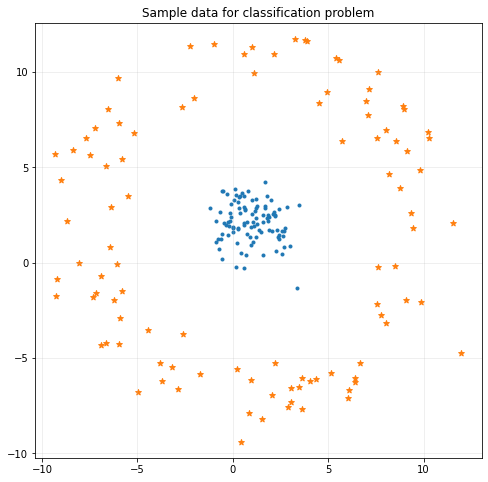

In [ ]:
fig1 = plt.figure(figsize=(8,8))
ax = plt.axes() 
plt.title('Sample data for classification problem')
plt.grid(axis='both', alpha=.25)
# plot graph here
# YOUR CODE HERE

plt.scatter(X1[:,0], X1[:,1], marker = '.', label='Class1')
plt.scatter(X2[:,0], X2[:,1], marker = '*', label='Class2')

#raise NotImplementedError()
# end plot graph
plt.axis('equal')
plt.show()

**Expect result (or looked alike):**

![lab05-1.png](attachment:lab05-1.png)

### Exercise 1.5 (5 points)

Split data into training and test datasets with 80% of training set and 20% of test set

In [ ]:
train_size = 0.8


# YOUR CODE HERE

idx = np.arange(len(X))
np.random.shuffle(idx)
idx_train = idx[:int(train_size*len(X))]
idx_test = idx[len(idx_train):len(idx)]

X_train = X[idx_train]
X_test = X[idx_test]
y_train = y[idx_train]
y_test =  y[idx_test]

#raise NotImplementedError()

In [ ]:
print('idx_train:', idx_train[:10])
print("train size, X:", X_train.shape, ", y:", y_train.shape)
print("test size,  X:", X_test.shape,  ", y:", y_test.shape)

# Test function: Do not remove
assert X_train.shape == (160, 2), 'Size of X_train is incorrect'
assert y_train.shape == (160,) or y_train.shape == (160,1) or y.shape == 160, 'Size of y_train is incorrect'
assert X_test.shape == (40, 2), 'Size of X_test is incorrect'
assert y_test.shape == (40,) or y_test.shape == (40,1) or y.shape == 40, 'Size of y_test is incorrect'

print("success!")
# End Test function

idx_train: [ 41  79 115 120  67 196 145 138  42  36]
train size, X: (160, 2) , y: (160,)
test size,  X: (40, 2) , y: (40,)
success!


**Expect reult (Or looked alike):**\
idx_train: [ 78  61  28 166  80 143   6  76  98 133]\
train size, X: (160, 2) , y: (160, 1) \
test size,  X: (40, 2) , y: (40, 1)

### Exercise 1.6 (5 points)

Write the function which normalize X set

#### Practice yourself (No grade, but has extra score 3 points)

Try to use Jupyter notebook to write the normalize equation.

$$ x_{norm} = \frac{X - \mu}{\sigma} $$

YOUR ANSWER HERE

In [ ]:
def normalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    X_norm = None
    # YOUR CODE HERE

    X_norm = (X-np.mean(X))/(np.std(X))


   # raise NotImplementedError()
    
    return X_norm

In [ ]:
XX = normalization(X)

X_train_norm = XX[idx_train]
X_test_norm = XX[idx_test]

# Add 1 at the first column of training dataset (for bias) and use it when training
X_design_train = np.insert(X_train_norm,0,1,axis=1)
X_design_test = np.insert(X_test_norm,0,1,axis=1)

m,n = X_design_train.shape

print(X_train_norm.shape)
print(X_design_train.shape)
print(X_test_norm.shape)
print(X_design_test.shape)

# Test function: Do not remove
assert XX[:,0].min() >= -2.5 and XX[:,0].max() <= 2.5, 'Does the XX is normalized?'
assert XX[:,1].min() >= -2.5 and XX[:,1].max() <= 2.5, 'Does the XX is normalized?'

print("success!")
# End Test function

(160, 2)
(160, 3)
(40, 2)
(40, 3)
success!


### Exercise 1.7 (10 points)

define class for logistic regression: batch gradient descent

The class includes:

 - **Sigmoid** function $$sigmoid(z) = \frac{1}{1+e^{-z}}$$
 - **Softmax** function $$softmax(z) = \frac{e^{z_i}}{\sum_n{e^z}}$$
 - **Hyperthesis (h)** function $$\hat{y} = h(X;\theta) = softmax(\theta . X)$$
 - **Gradient (Negative likelihood)** function $$gradient = - X . \frac{y-\hat{y}}{n}$$
 - **Cost** function $$cost = \frac{\sum{((-y\log{\hat{y}}) - ((1-y)\log{(1 - \hat{y})})})}{n}$$
 - **Gradient ascent** function
 - **Prediction** function
 - **Get accuracy** funciton

In [ ]:
class Logistic_BGD:
    def __init__(self):
        pass
    
    def sigmoid(self,z):
        s = 1/(1+np.exp(-z))

        #raise NotImplementedError()
        return s

    def softmax(self, z):
        sm = np.exp(z)/np.sum(np.exp(z))

        #raise NotImplementedError()
        return sm
    
    def h(self,X, theta):
        hf =  self.sigmoid(X @ theta)

        #raise NotImplementedError()
        return hf
    
    def gradient(self, X, y, y_pred):
        grad = -X.T @ ((y-y_pred)/y.shape[0])

        #raise NotImplementedError()
        return grad
        
    def costFunc(self, theta, X, y):
        y_hat = self.h(X,theta)
        cost = (np.sum((-y*np.log(y_hat))-(1-y)*np.log(1-y_hat)))/y.shape[0]
        grad = self.gradient(X,y, y_hat)
        # YOUR CODE HERE
        #raise NotImplementedError()
        return cost, grad
    
    def gradientAscent(self, X, y, theta, alpha, num_iters):
        m = len(y)
        J_history = []
        theta_history = []
        for i in range(num_iters):
            # 1. calculate cost, grad function
            # 2. update new theta
            cost, grad = self.costFunc(theta, X,y)
            theta = theta - alpha * grad
            
            #raise NotImplementedError()
            
            
            J_history.append(cost)
            theta_history.append(theta)
        J_min_index = np.argmin(J_history)
        print("Minimum at iteration:",J_min_index)
        return theta_history[J_min_index] , J_history

    def predict(self,X, theta):
        labels=[]
        # 1. take y_predict from hyperthesis function
        # 2. classify y_predict that what it should be class1 or class2
        # 3. append the output from prediction
        # YOUR CODE HERE

        labels=[]
        # 1. take y_predict from hyperthesis function
        y_predict = self.h(X, theta)
        # 2. classify y_predict that what it should be class1 or class2 
        prediction = (y_predict > 0.5).astype(int).reshape(-1)
        # 3. append the output from prediction
        for p in prediction:
          labels.append(p) 
        labels=np.asarray(labels)
        return labels
     
    def getAccuracy(self,X,y,theta):
        # percent_correct = None
        # # YOUR CODE HERE
        # # y_predict = self.predict(X, theta).reshape(y.shape)
        # # percent_correct = ((y == y_predict).astype(int).sum() / y.shape[0])*100
        # y_pred = self.predict(X, theta)
        # y_prediction = np.sum(y_pred == y.T)
        # overall = y.size
        # percent_correct = (float(y_prediction)/float(overall)) * 100

        #raise NotImplementedError()
        y_predict = self.predict(X, theta).reshape(y.shape)
        percent_correct = ((y == y_predict).astype(int).sum() / y.shape[0])*100

        return percent_correct

In [ ]:
# Test function: Do not remove
lbgd = Logistic_BGD()
test_x = np.array([[1,2,3,4,5]]).T
out_x1 = lbgd.sigmoid(test_x)
out_x2 = lbgd.sigmoid(test_x.T)
print('out_x1', out_x1.T)
assert np.array_equal(np.round(out_x1.T, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
assert np.array_equal(np.round(out_x2, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
out_x1 = lbgd.softmax(out_x1)
out_x2 = lbgd.softmax(out_x2)
print('out_x1', out_x1.T)
assert np.array_equal(np.round(out_x1.T, 5), np.round([[0.16681682, 0.19376282, 0.20818183, 0.21440174, 0.21683678]], 5)), "softmax function is incorrect"
assert np.array_equal(np.round(out_x2, 5), np.round([[0.16681682, 0.19376282, 0.20818183, 0.21440174, 0.21683678]], 5)), "softmax function is incorrect"
test_t = np.array([[0.3, 0.2]]).T
test_x = np.array([[1,2,3,4,5, 6], [2, 9, 4, 3, 1, 0]]).T
test_y = np.array([[0,1,0,1,0,1]]).T
test_y_p = lbgd.h(test_x, test_t)
print('test_y_p', test_y_p.T)
assert np.array_equal(np.round(test_y_p.T, 5), np.round([[0.66818777, 0.9168273, 0.84553473, 0.85814894, 0.84553473, 0.85814894]], 5)), "hyperthesis function is incorrect"
test_g = lbgd.gradient(test_x, test_y, test_y_p)
print('test_g', test_g.T)
assert np.array_equal(np.round(test_g.T, 5), np.round([[0.9746016, 0.73165696]], 5)), "gradient function is incorrect"
test_c, test_g = lbgd.costFunc(test_t, test_x, test_y)
print('test_c', test_c.T)
assert np.round(test_c, 5) == np.round(0.87192491, 5), "costFunc function is incorrect"
test_t_out , test_j = lbgd.gradientAscent(test_x, test_y, test_t, 0.001, 3)
print('test_t_out', test_t_out.T)
print('test_j', test_j)
assert np.array_equal(np.round(test_t_out.T, 5), np.round([[0.29708373, 0.19781153]], 5)), "gradientAscent function is incorrect"
assert np.round(test_j[2], 5) == np.round(0.86896665, 5), "gradientAscent function is incorrect"
test_l = lbgd.predict(test_x, test_t)
print('test_l', test_l)
assert np.array_equal(np.round(test_l, 1), np.round([1,1,1,1,1,1], 1)), "gradientAscent function is incorrect"
test_a = lbgd.getAccuracy(test_x,test_y,test_t)
print('test_a', test_a)
assert np.round(test_a, 1) == 50.0, "getAccuracy function is incorrect"

print("success!")
# End Test function

out_x1 [[0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]]
out_x1 [[0.16681682 0.19376282 0.20818183 0.21440174 0.21683678]]
test_y_p [[0.66818777 0.9168273  0.84553473 0.85814894 0.84553473 0.85814894]]
test_g [[0.9746016  0.73165696]]
test_c 0.8719249134773479
Minimum at iteration: 2
test_t_out [[0.29708373 0.19781153]]
test_j [0.8719249134773479, 0.870441756946089, 0.8689666485816598]
test_l [1 1 1 1 1 1]
test_a 50.0
success!


**Expect result:**\
out_x1 [[0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]]\
out_x1 [[0.16681682 0.19376282 0.20818183 0.21440174 0.21683678]]\
test_y_p [[0.66818777 0.9168273  0.84553473 0.85814894 0.84553473 0.85814894]]\
test_g [[0.9746016  0.73165696]]\
test_c [0.87192491]\
Minimum at iteration: 2\
test_t_out [[0.29708373 0.19781153]]\
test_j [array([0.87192491]), array([0.87044176]), array([0.86896665])]\
test_l [1 1 1 1 1 1]\
test_a 50.0

### Exercise 1.8 (5 points)

Training the data using Logistic_BGD class.
 - Input: X_design_train
 - Output: y_train
 - Use 50,000 iterations
 
Find the initial_theta yourself

In [ ]:
alpha = 0.001
iterations = 50000

BGD_model = Logistic_BGD()
initial_theta = np.zeros((n,))
bgd_theta, bgd_cost = BGD_model.gradientAscent(X_design_train, y_train, initial_theta, alpha, iterations)
#raise NotImplementedError(),

Minimum at iteration: 49999


[ 0.01753215  0.09165556 -0.17434941]
50000
0.6931471805599453


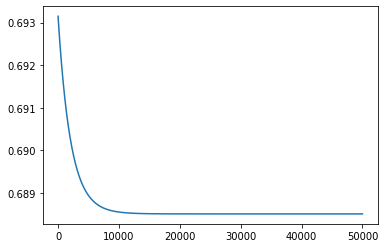

success!


In [ ]:
print(bgd_theta)
print(len(bgd_cost))

print(bgd_cost[0])
plt.plot(bgd_cost)
plt.show()

# Test function: Do not remove
assert bgd_theta.shape == (X_train.shape[1] + 1,1) or bgd_theta.shape == (X_train.shape[1] + 1,) or bgd_theta.shape == X_train.shape[1] + 1, "theta shape is incorrect"
assert len(bgd_cost) == iterations, "cost data size is incorrect"

print("success!")
# End Test function

**Expect result (or look alike):**\
[[-0.07328673]\
 [-0.13632896]\
 [ 0.05430939]]\
50000

![lab05-2.png](attachment:lab05-2.png)

## In lab exercises

1. Verify that the gradient descent solution is correct. Plot the optimal decision boundary you obtain.

2. Write a new class that uses Newton's method for the optmization rather than simple gradient descent.

3. Verify that you obtain a similar solution with Newton's method. Plot the optimal decision boundary you obtain.

4. Compare the number of iterations required for gradient descent vs. Newton's method. Do you observe other issues
   with Newton's method such as a singular or nearly singular Hessian matrix?


### Exercise 1.9 (5 points)

Plot the optimal decision boundary of gradient ascent

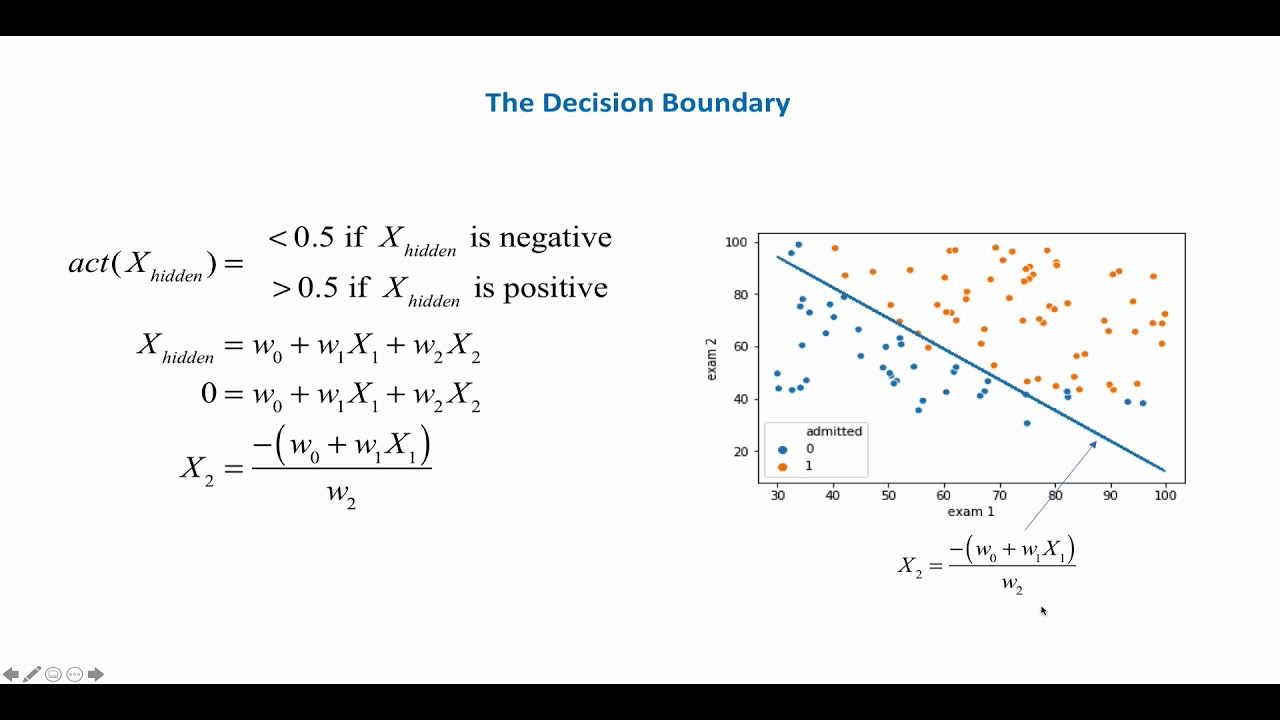

In [ ]:
def plot_decision_boundary(X, theta):

  y = - (theta[0] + theta[1]* X) / theta[2]
  return y

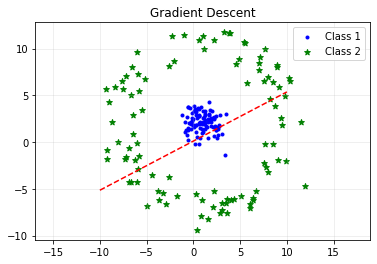

In [ ]:
plt.title('Gradient Descent')
plt.grid(axis='both', alpha=.25)
bound_x = np.linspace(-10,10,100)
bound_y = plot_decision_boundary(bound_x, bgd_theta)
plt.scatter(X1[:,0],X1[:,1],c='b',marker = '.',label = 'Class 1')
plt.scatter(X2[:,0],X2[:,1],c='g',marker = '*', label = 'Class 2')
plt.plot(bound_x,bound_y,'r--')
# plt.xlim([-15, 15])
# plt.ylim([-15, 15]) 


plt.axis('equal')
plt.legend()
# plt.show()

**Expect result (or look alike):**\
![lab05-3.png](attachment:lab05-3.png)

In [ ]:
y_test

array([0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1.])

In [ ]:
X_design_test

array([[ 1.        , -0.29366655,  0.10793802],
       [ 1.        , -0.48548986,  0.17852893],
       [ 1.        , -1.68101676,  0.332167  ],
       [ 1.        ,  1.34448197, -0.76914108],
       [ 1.        , -1.41942314,  1.17433192],
       [ 1.        , -0.16361324,  0.1268993 ],
       [ 1.        , -0.28024688,  0.41663202],
       [ 1.        ,  1.66817245, -0.71830191],
       [ 1.        ,  0.28287945, -0.12151149],
       [ 1.        , -0.1682009 ,  2.07522684],
       [ 1.        ,  0.94474973,  1.07949868],
       [ 1.        , -0.16641964,  0.46560312],
       [ 1.        , -1.54765258,  0.88064681],
       [ 1.        ,  0.36320618, -1.87722742],
       [ 1.        , -0.45198619, -0.14025927],
       [ 1.        , -0.13173865,  0.03545331],
       [ 1.        , -0.36423774,  0.48591344],
       [ 1.        , -1.73593017,  0.80199493],
       [ 1.        , -0.11241819, -2.00219845],
       [ 1.        , -0.08822817, -0.09317269],
       [ 1.        , -0.10335406, -0.004

In [ ]:
print("Accuracy =",BGD_model.getAccuracy(X_design_test,y_test,bgd_theta))

Accuracy = 57.49999999999999


### Exercise 2.1 (10 points)

Write Newton's method class

In [ ]:
class Logistic_NM: #logistic regression for newton's method
      
    def __init__(self):
        pass
    
    def sigmoid(self,z):
        s = None
        # YOUR CODE HERE
        s = 1/(1+np.exp(-z))
        #raise NotImplementedError()
        return s

    def h(self,X, theta):

        # YOUR CODE HERE

        hf =  self.sigmoid(X @ theta)
        #hf = self.sigmoid(X.dot(theta))
        #raise NotImplementedError()
        return hf

    def gradient(self, X, y, y_pred):
        grad = None
        # YOUR CODE HERE
        m = len(y)
        grad = -X.T.dot(y - y_pred) / m

        #raise NotImplementedError()
        return grad
        
    def hessian(self, X, y, theta):

        # YOUR CODE HERE
        m = len(y)
        y_pred = self.h(X, theta).reshape(-1,1)
        hess_mat = (X.T @ (X)) * ((y_pred.T @ (1-y_pred))[0,0])/m


        #raise NotImplementedError()
        return hess_mat
        
    def costFunc(self, theta, X, y):   
        cost, grad = None, None
        # YOUR CODE HERE
        m = len(y)
        y_pred = self.h(X, theta)
        cost = (np.sum((-y*np.log(y_pred))-(1-y)*np.log(1-y_pred)))/y.shape[0]
        grad = self.gradient(X,y, y_pred)


        #raise NotImplementedError()
        return cost, grad
    
    def newtonsMethod(self, X, y, theta, num_iters):
        m = len(y)
        J_history = []
        theta_history = []
        for i in range(num_iters):
            # YOUR CODE HERE
            #raise NotImplementedError()
            
            cost, grad = self.costFunc(theta,X,y)
            theta = theta - np.linalg.inv(self.hessian(X,y,theta))@grad 
            

            J_history.append(cost)
            theta_history.append(theta)
        J_min_index = np.argmin(J_history)
        print("Minimum at iteration:", J_min_index)
        return theta_history[J_min_index] , J_history


    def predict(self,X, theta): 
        labels=[]
        for i in range(0,X.shape[0]): 
          y1=self.h(X[i].reshape(1,-1),theta) 
          if y1 >= 0.5:
              labels.append(1) 
          else:
              labels.append(0)
        labels=np.asarray(labels) 
        return labels

     
    def getAccuracy(self,X,y,theta):
        percent_correct = None
        # YOUR CODE HERE
        y_predict = self.predict(X, theta).reshape(y.shape)
        percent_correct = ((y == y_predict).astype(int).sum() / y.shape[0])*100

        #raise NotImplementedError()
        return percent_correct

In [ ]:
# Test function: Do not remove
lbgd = Logistic_NM()
test_x = np.array([[1,2,3,4,5]]).T
out_x1 = lbgd.sigmoid(test_x)
out_x2 = lbgd.sigmoid(test_x.T)
print('out_x1', out_x1.T)
assert np.array_equal(np.round(out_x1.T, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
assert np.array_equal(np.round(out_x2, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
test_t = np.array([[0.3, 0.2]]).T
test_x = np.array([[1,2,3,4,5, 6], [2, 9, 4, 3, 1, 0]]).T
test_y = np.array([[0,1,0,1,0,1]]).T
test_y_p = lbgd.h(test_x, test_t)
print('test_y_p', test_y_p.T)
assert np.array_equal(np.round(test_y_p.T, 5), np.round([[0.66818777, 0.9168273, 0.84553473, 0.85814894, 0.84553473, 0.85814894]], 5)), "hyperthesis function is incorrect"
test_g = lbgd.gradient(test_x, test_y, test_y_p)
print('test_g', test_g.T)
assert np.array_equal(np.round(test_g.T, 5), np.round([[0.9746016, 0.73165696]], 5)), "gradient function is incorrect"
test_h = lbgd.hessian(test_x, test_y, test_t)
print('test_h', test_h)
assert test_h.shape == (2, 2), "hessian matrix function is incorrect"
assert np.array_equal(np.round(test_h.T, 5), np.round([[12.17334371, 6.55487738],[ 6.55487738, 14.84880387]], 5)), "hessian matrix function is incorrect"
test_c, test_g = lbgd.costFunc(test_t, test_x, test_y)
print('test_c', test_c.T)
assert np.round(test_c, 5) == np.round(0.87192491, 5), "costFunc function is incorrect"
test_t_out , test_j = lbgd.newtonsMethod(test_x, test_y, test_t, 3)
print('test_t_out', test_t_out.T)
print('test_j', test_j)
assert np.array_equal(np.round(test_t_out.T, 5), np.round([[0.14765747, 0.15607017]], 5)), "newtonsMethod function is incorrect"
assert np.round(test_j[2], 5) == np.round(0.7534506190845247, 5), "newtonsMethod function is incorrect"
test_l = lbgd.predict(test_x, test_t)
print('test_l', test_l)
assert np.array_equal(np.round(test_l, 1), np.round([1,1,1,1,1,1], 1)), "gradientAscent function is incorrect"
test_a = lbgd.getAccuracy(test_x,test_y,test_t)
print('test_a', test_a)
assert np.round(test_a, 1) == 50.0, "getAccuracy function is incorrect"

print("success!")
# End Test function

out_x1 [[0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]]
test_y_p [[0.66818777 0.9168273  0.84553473 0.85814894 0.84553473 0.85814894]]
test_g [[0.9746016  0.73165696]]
test_h [[12.17334371  6.55487738]
 [ 6.55487738 14.84880387]]
test_c 0.8719249134773479
Minimum at iteration: 2
test_t_out [[0.14765747 0.15607017]]
test_j [0.8719249134773479, 0.7967484437157274, 0.7534506190845246]
test_l [1 1 1 1 1 1]
test_a 50.0
success!


**Expect result:**
out_x1 [[0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]]\
test_y_p [[0.66818777 0.9168273  0.84553473 0.85814894 0.84553473 0.85814894]]\
test_g [[0.9746016  0.73165696]]\
test_h [[12.17334371  6.55487738]\
 [ 6.55487738 14.84880387]]\
test_c 0.8719249134773479\
Minimum at iteration: 2\
test_t_out [[0.14765747 0.15607017]]\
test_j [0.8719249134773479, 0.7967484437157274, 0.7534506190845247]\
test_l [1 1 1 1 1 1]\
test_a 50.0

Minimum at iteration: 999
theta: [ 0.01749179  0.0914599  -0.17398192]
0.6931471805599453


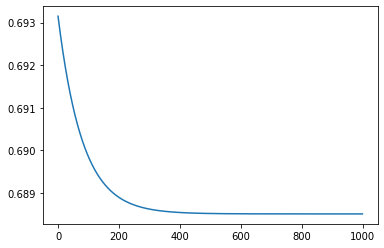

In [ ]:
NM_model = Logistic_NM()

iterations = 1000

nm_theta, nm_cost = NM_model.newtonsMethod(X_design_train, y_train, initial_theta, iterations)
print("theta:",nm_theta)

print(nm_cost[0])
plt.plot(nm_cost)
plt.show()

**Expect result (or look alike):**\
Minimum at iteration: 999\
theta: [[-0.07313861]\
 [-0.13605172]\
 [ 0.05419746]]\
0.6931471805599453

![lab05-4.png](attachment:lab05-4.png)

### Exercise 2.2 (5 points)

Plot the optimal decision boundary of Newton method

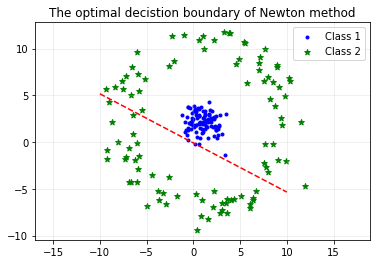

In [ ]:
# YOUR CODE HERE

def plot_decision_boundary(X, theta):

  y = (theta[0] + theta[1]* X) / theta[2]
  return y


plt.title('The optimal decistion boundary of Newton method')
plt.grid(axis='both', alpha=.25)
bound_x = np.linspace(-10,10,100)
bound_y = plot_decision_boundary(bound_x, nm_theta)
plt.scatter(X1[:,0],X1[:,1],c='b',marker = '.',label = 'Class 1')
plt.scatter(X2[:,0],X2[:,1],c='g',marker = '*', label = 'Class 2')
plt.plot(bound_x,bound_y,'r--')
# plt.xlim([-15, 15])
# plt.ylim([-15, 15]) 


plt.axis('equal')
plt.legend()
# plt.show()



#raise NotImplementedError()

**Expect result (or look alike):**

![lab05-5.png](attachment:lab05-5.png)

In [ ]:
print("Accuracy =",NM_model.getAccuracy(X_design_test,y_test,bgd_theta))

Accuracy = 57.49999999999999


### Exercise 2.3 (5 points)

Compare the number of iterations required for gradient descent vs. Newton's method. Do you observe other issues with Newton's method such as a singular or nearly singular Hessian matrix?

**Gradient descent requires up to nearly 50,000 iterations to achieve the lowest cost of approximately 0.69.**

**As for Newton's method, the number of iterations is reduced to approximately 1000 times to achieve a similar cost of 0.69.**

**In light of the computational cost, this indicates that Newton's method is significantly more effective than gradient descent.**

**An issue that may arise is when the hessian matrix is singular which means that the inverse doesn't exist, that is an issue because we need that inverse**

## Take-home exercises

1. Perform a *polar transformation* on the data above to obtain a linearly separable dataset. (5 points)

2. Verify that you obtain good classification accuracy for logistic regression with GD or Netwon's method
   after the polar transformation (10 points)
   
3. Apply Newton's method to the dataset you used for the take home exercises in Lab 03. (20 points)




# 1) Perform a *polar transformation* on the data above to obtain a linearly separable dataset. (5 points) 

In [ ]:
# x = r*np.cos(theta)
# y = r*np.sin(theta)
# r = np.sqrt(x**2 + y**2)
#angle  = np.arctan(y/x)

In [ ]:
angles = np.arctan((X[:,1]/X[:,0]))
radius = np.sqrt(X[:,1]**2 + X[:,0]**2)

In [ ]:
angles.shape, radius.shape

((200,), (200,))

In [ ]:
X_polar = np.vstack((angles, radius)).T
X_polar.shape

(200, 2)

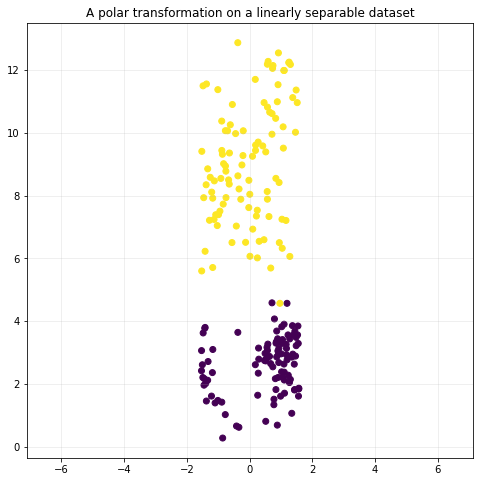

In [ ]:
fig1 = plt.figure(figsize=(8,8))
ax = plt.axes() 
plt.title('A polar transformation on a linearly separable dataset')
plt.grid(axis='both', alpha=.25)
# plot graph here
# YOUR CODE HERE

# plt.scatter(X_polar[:,0], X[:,1], marker = '.', label='Class1')
# plt.scatter(X_polar[:,0], X[:,1], marker = '*', label='Class2')
plt.scatter(angles, radius, c=y)
#raise NotImplementedError()
# end plot graph
plt.axis('equal')
plt.show()

# 2. Verify that you obtain good classification accuracy for logistic regression with GD or Netwon's method after the polar transformation (10 points)

In [ ]:
X_p = np.vstack((angles, radius)).T
XX_p = normalization(X_p)

X_p_train = XX_p[idx_train]
X_p_test = XX_p[idx_test]

X_p_design_train = np.insert(X_p_train,0,1,axis=1)
X_p_design_test = np.insert(X_p_test,0,1,axis=1)


print(X_p_design_train.shape, X_p_design_test.shape)

(160, 3) (40, 3)


Minimum at iteration: 999
theta: [-4.22349542 -1.56086725  4.98355048]
0.6931471805599453
Done


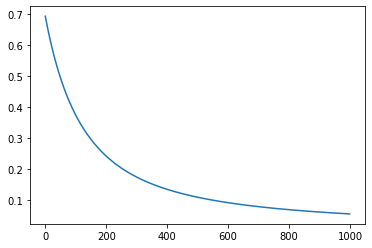

In [ ]:
NM_model_POLAR = Logistic_NM()

iterations = 1000

initial_theta = np.zeros((X_p_design_train.shape[1],))

polar_theta, polar_cost = NM_model_POLAR.newtonsMethod(X_p_design_train, y_train, initial_theta, iterations)
print("theta:",polar_theta)

print(polar_cost[0])
plt.plot(polar_cost)
print("Done")
plt.show()

# 3. Apply Newton's method to the dataset you used for the take home exercises in Lab 03. (20 points)

In [ ]:
import pandas as pd

In [ ]:
data_train = pd.read_csv('train_LoanPrediction.csv')
data_test = pd.read_csv('test_LoanPrediction.csv')

# Cleaning Data Process

In [ ]:
print(data_train['Married'].value_counts())

married = data_train['Married'].value_counts()
print('Elements in Married variable', married.shape)
print('Married ratio ', married[0]/sum(married.values))

def fill_martial_status(data, yes_num_train, no_num_train):        
    data['Married'].fillna('Yes', inplace = True, limit = yes_num_train)
    data['Married'].fillna('No', inplace = True, limit = no_num_train)  

fill_martial_status(data_train, 2, 1)
print(data_train['Married'].value_counts()) 
print('Missing values for train data:\n------------------------\n', data_train.isnull().sum())

Yes    398
No     213
Name: Married, dtype: int64
Elements in Married variable (2,)
Married ratio  0.6513911620294599
Yes    400
No     214
Name: Married, dtype: int64
Missing values for train data:
------------------------
 Loan_ID               0
Gender               13
Married               0
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [ ]:
# Another example of filling in missing values for the "number of dependents" attribute.
# Here we see that categorical values are all numeric except one value "3+" 
# Create a new category value "4" for "3+" and ensure that all the data is numeric

print(data_train['Dependents'].value_counts())
dependent = data_train['Dependents'].value_counts()

print('Dependent ratio 1 ', dependent['0'] / sum(dependent.values))
print('Dependent ratio 2 ', dependent['1'] / sum(dependent.values))
print('Dependent ratio 3 ', dependent['2'] / sum(dependent.values))
print('Dependent ratio 3+ ', dependent['3+'] / sum(dependent.values))

def fill_dependent_status(num_0_train, num_1_train, num_2_train, num_3_train, num_0_test, num_1_test, num_2_test, num_3_test):        
    data_train['Dependents'].fillna('0', inplace=True, limit = num_0_train)
    data_train['Dependents'].fillna('1', inplace=True, limit = num_1_train)
    data_train['Dependents'].fillna('2', inplace=True, limit = num_2_train)
    data_train['Dependents'].fillna('3+', inplace=True, limit = num_3_train)
    data_test['Dependents'].fillna('0', inplace=True, limit = num_0_test)
    data_test['Dependents'].fillna('1', inplace=True, limit = num_1_test)
    data_test['Dependents'].fillna('2', inplace=True, limit = num_2_test)
    data_test['Dependents'].fillna('3+', inplace=True, limit = num_3_test)

fill_dependent_status(9, 2, 2, 2, 5, 2, 2, 1)

print(data_train['Dependents'].value_counts())

# Convert category value "3+" to "4"

data_train['Dependents'].replace('3+', 4, inplace = True)
data_test['Dependents'].replace('3+', 4, inplace = True)


0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Dependent ratio 1  0.5759599332220368
Dependent ratio 2  0.17028380634390652
Dependent ratio 3  0.1686143572621035
Dependent ratio 3+  0.08514190317195326
0     354
1     104
2     103
3+     53
Name: Dependents, dtype: int64


In [ ]:
print(data_train['LoanAmount'].value_counts())

LoanAmt = data_train['LoanAmount'].value_counts()

print('mean loan amount ', np.mean(data_train["LoanAmount"]))

loan_amount_mean = np.mean(data_train["LoanAmount"])

data_train['LoanAmount'].fillna(loan_amount_mean, inplace=True, limit = 22)
data_test['LoanAmount'].fillna(loan_amount_mean, inplace=True, limit = 5)

120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: LoanAmount, Length: 203, dtype: int64
mean loan amount  146.41216216216216


**Fill in data first**

In [ ]:
def fill_ratio(data_train, data_test, column): 
  count_column = data_train[column].value_counts() 
  values_list = list(count_column.index)
  
  num_train = [] 
  num_test = []

  for value in values_list:
    ratio = count_column[value]/sum(count_column.values) 
    num_train.append(round(ratio * data_train[column].isnull().sum())) 
    num_test.append(round(ratio * data_test[column].isnull().sum()))
  for idx, va_lim in enumerate(num_train): 
    data_train[column].fillna(values_list[idx], inplace = True, limit = va_lim)
  for idx, va_lim in enumerate(num_test): 
    data_test[column].fillna(values_list[idx], inplace = True, limit = va_lim)

In [ ]:
#By ratio
fill_ratio(data_train, data_test,'Gender') 
fill_ratio(data_train, data_test,'Self_Employed') 
fill_ratio(data_train, data_test,'Credit_History')

#By Median
data_test['Loan_Amount_Term'].fillna(data_test['Loan_Amount_Term'].median(), inplace = True) 
data_train['Loan_Amount_Term'].fillna(data_train['Loan_Amount_Term'].median(), inplace = True)

In [ ]:
data_train.loc[data_train['Gender'] == 'Male', 'Gender'] = 1 
data_train.loc[data_train['Gender'] == 'Female', 'Gender'] = 0 

data_train.loc[data_train['Married'] == 'Yes', 'Married'] = 1 
data_train.loc[data_train['Married'] == 'No', 'Married'] = 0 

data_train.loc[data_train['Education'] == 'Graduate', 'Education'] = 1 
data_train.loc[data_train['Education'] == 'Not Graduate', 'Education'] = 0

data_train.loc[data_train['Self_Employed'] == 'Yes', 'Self_Employed'] = 1 
data_train.loc[data_train['Self_Employed'] == 'No', 'Self_Employed'] = 0 

data_train.loc[data_train['Property_Area'] == 'Urban', 'Property_Area'] = 3 
data_train.loc[data_train['Property_Area'] == 'Semiurban', 'Property_Area'] = 2 
data_train.loc[data_train['Property_Area'] == 'Rural', 'Property_Area'] = 1 
data_train.loc[data_train['Property_Area'] == '0', 'Property_Area'] = 0

data_train.loc[data_train['Loan_Status'] == 'Y', 'Loan_Status'] = 1 
data_train.loc[data_train['Loan_Status'] == 'N', 'Loan_Status'] = 0


In [ ]:
data_test.loc[data_test['Gender'] == 'Male', 'Gender'] = 1 
data_test.loc[data_test['Gender'] == 'Female', 'Gender'] = 0 

data_test.loc[data_test['Married'] == 'Yes', 'Married'] = 1 
data_test.loc[data_test['Married'] == 'No', 'Married'] = 0 

data_test.loc[data_test['Education'] == 'Graduate', 'Education'] = 1 
data_test.loc[data_test['Education'] == 'Not Graduate', 'Education'] = 0 

data_test.loc[data_test['Self_Employed'] == 'Yes', 'Self_Employed'] = 1 
data_test.loc[data_test['Self_Employed'] == 'No', 'Self_Employed'] = 0 

data_test.loc[data_test['Property_Area'] == 'Urban', 'Property_Area'] = 3 
data_test.loc[data_test['Property_Area'] == 'Semiurban', 'Property_Area'] = 2 
data_test.loc[data_test['Property_Area'] == 'Rural', 'Property_Area'] = 1 
data_test.loc[data_test['Property_Area'] == '0', 'Property_Area'] = 0

In [ ]:
data_test.sample(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
344,LP002876,1,0,0,1,0,6858,0,176.0,360.0,1.0,1
329,LP002816,1,1,1,1,0,3500,1658,104.0,360.0,1.0,2
211,LP002168,1,0,0,1,0,5333,2400,200.0,360.0,0.0,1
277,LP002550,0,0,0,1,0,5769,0,110.0,180.0,1.0,2
203,LP002117,0,1,0,1,0,3159,2374,108.0,360.0,1.0,2
254,LP002397,0,1,1,1,0,3719,1585,114.0,360.0,1.0,3
53,LP001298,1,1,2,1,0,4116,1000,30.0,180.0,1.0,3
350,LP002899,1,1,2,1,0,8667,0,254.0,360.0,1.0,1
151,LP001831,1,1,0,1,0,2783,1456,113.0,360.0,1.0,3
295,LP002612,0,1,0,1,0,2666,0,84.0,480.0,1.0,2


In [ ]:
#data train
data_train['Gender'] = data_train['Gender'].astype('int') 
data_train['Married'] = data_train['Married'].astype('int') 
data_train['Dependents'] = data_train['Dependents'].astype('int') 
data_train['Education'] = data_train['Education'].astype('int') 
data_train['Self_Employed'] = data_train['Self_Employed'].astype('int') 
data_train['Property_Area'] = data_train['Property_Area'].astype('int')
data_train['Loan_Status'] = data_train['Loan_Status'].astype('int')

#data test
data_test['Gender'] = data_test['Gender'].astype('int') 
data_test['Married'] = data_test['Married'].astype('int') 
data_test['Dependents'] = data_test['Dependents'].astype('int') 
data_test['Education'] = data_test['Education'].astype('int') 
data_test['Self_Employed'] = data_test['Self_Employed'].astype('int') 
data_test['Property_Area'] = data_test['Property_Area'].astype('int')

In [ ]:
import random

X_train = np.array(data_train.iloc[:,1:-1]) 
y_train = np.array(data_train.iloc[:,-1]) 
X_test = np.array(data_test.iloc[:,1:])


#normalize
m, n = X_train.shape
X = np.append(X_train, X_test, axis=0)
X_norm = (X - np.mean(X))/np.std(X)
X_train_norm = X_norm[:m,:]
X_test_norm = X_norm[m:,:]

# partition
m, n = X_train.shape
XX_train_val = np.insert(X_train_norm, 0, 1, axis=1) 
yy_train_val = y_train.reshape(m, 1)

idx = np.arange(0, m) 
random.shuffle(idx) 
percent_train = .7
m_train = int(m * percent_train) 
train_idx = idx[0:m_train] 
val_idx = idx[m_train:]
XX_train = XX_train_val[train_idx,:]; 
XX_val = XX_train_val[val_idx,:];

yy_train = yy_train_val[train_idx]; 
yy_val = yy_train_val[val_idx];


In [ ]:
print(XX_train.shape, XX_val.shape, yy_train.shape, yy_val.shape)

(429, 12) (185, 12) (429, 1) (185, 1)


In [ ]:
print(XX_train.shape, yy_train.reshape(-1).shape, initial_theta.shape)

(429, 12) (429,) (12,)


Minimum at iteration: 999
theta: [ 2.22171041e+03 -2.15255235e+02  1.03405431e+03 -6.14280959e+01
  1.02614923e+03 -8.96469928e+01  3.33750909e-02 -1.25617118e-01
 -1.86221042e+00 -7.98071845e-01  6.24944188e+03  2.04200067e+02]
0.6931471805599453
Done


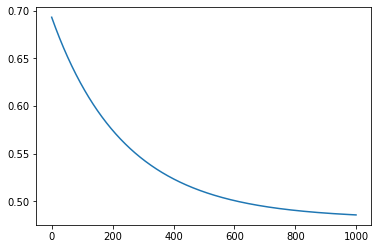

In [ ]:
model_new = Logistic_NM()

iterations = 1000

initial_theta = np.zeros((XX_train.shape[1],))

new_theta, new_cost = model_new.newtonsMethod(XX_train, yy_train.reshape(-1), initial_theta, iterations)
print("theta:",new_theta)

print(new_cost[0])
plt.plot(new_cost)
print("Done")
plt.show()

In [ ]:
new_acc = model_new.getAccuracy(XX_val, yy_val, new_theta)
print('The accuracy using Newton method and loan prediction is ', new_acc)

The accuracy using Newton method and loan prediction is  81.62162162162161


## The report

Write a brief report covering your experiments (both in lab and take home) and send as a Jupyter notebook
to the TAs, Manish and Abhishek before the next lab.

In your solution, be sure to follow instructions.

The accuracy I obtained in previous labs using logistic regression was about 71.54. Using Newton's method instead, accuracy improved to 81.6%.

We saw in this lab that using Newton's method can be better than using normal gradient descent as it converges faster. Using gradient descent we needed up to 50,000 iterations to get a cost of 0.69, whereas with Newston method we only need 1000 iterations.

